In [1]:
import common
import importlib
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import socket
import plotting
import matplotlib.style
import matplotlib.ticker as ticker
from matplotlib.container import BarContainer

# Show all columns and rows in a dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
experiments = "(hostname == 'scyper21' or hostname == 'scyper22')"

libraries = ["g1_v6-ref-ignore-build", "livegraph3_ro", "llama8-ref", "sortledton.1", "sortledton.3", "sortledton.2", "sortledton", "stinger7-ref", "teseo-lcc.12"]
libraries_filter = " | ".join(map(lambda l: "library == '" + l + "'", libraries))

edges_per_graph = pd.DataFrame({
    "graph": ["com-friendster", "dota-league", "graph500-22", 
              "graph500-24", "graph500-26", "uniform-22", 
              "uniform-24", "uniform-26"
              ],
    "edges": [1806067135, 50870313, 64155735, 260379520, 1051922853, 64155735, 260379520, 1051922853]
})

data = common.import_gfe("View_Inserts").query(experiments).copy() # data from the experiments
data["build_frequency"].fillna(pd.Timedelta(0), inplace=True) # replace NaT with 0, otherwise the records are ignored in the group by
data["block_size"].fillna(-1, inplace=True)
data = data.query("((block_size == 512) and library == 'sortledton.3') or library != 'sortledton.3'") 
data = data.merge(edges_per_graph, on="graph")
data["edges_per_second"] = data["edges"] / data["completion_time_secs"]

data = data.query(libraries_filter)
data = data.query("graph != 'uniform-22'")
data.columns

Index(['exec_id', 'cluster', 'hostname', 'mode', 'library', 'graph',
       'is_directed', 'compiler_family', 'compiler', 'num_threads',
       'omp_threads', 'num_validation_errors', 'has_latency', 'scheduler',
       'build_frequency', 'build_frequency_secs', 'num_build_invocations',
       'num_snapshots_created', 'insertion_time', 'insertion_time_secs',
       'insertion_time_perc', 'build_time', 'build_time_secs',
       'build_time_perc', 'completion_time', 'completion_time_secs',
       'block_size', 'edges', 'edges_per_second'],
      dtype='object')

In [3]:
data_grouped = data.groupby(["compiler_family", "graph", "library", "build_frequency", "num_threads"]) \
    .agg(secs=("completion_time_secs", "median"), std_eps=("edges_per_second", "std"), edges_per_second=("edges_per_second", "median"), count=("edges_per_second", "count"))
data_grouped["cov"] = data_grouped["std_eps"] / data_grouped["edges_per_second"]
data_grouped.drop(["std_eps"], axis=1, inplace=True)
data_grouped.index.set_names("compiler", level=1, inplace=True)
data_grouped

secs  \
compiler_family compiler       library                build_frequency num_threads                 
gcc             com-friendster g1_v6-ref-ignore-build 0 days 00:00:00 20             523.730017   
                               livegraph3_ro          0 days 00:00:00 20            5376.799135   
                               sortledton             0 days 00:00:00 56             379.998897   
                               sortledton.1           0 days 00:00:00 56             426.035401   
                               sortledton.2           0 days 00:00:00 56             425.976328   
                               sortledton.3           0 days 00:00:00 56             409.001890   
                               teseo-lcc.12           0 days 00:00:00 56             644.516688   
                dota-league    g1_v6-ref-ignore-build 0 days 00:00:00 20              13.927041   
                               livegraph3_ro          0 days 00:00:00 20             150.884678   
                               llama8-ref             0 days 00:00:10 16             120.932116   
                               sortledton             0 days 00:00:00 56              13.730899   
                               sortledton.1           0 days 00:00:00 56              14.465427   
                               sortledton.2           0 days 00:00:00 56              14.741421   
                               sortledton.3           0 days 00:00:00 56              14.342846   
                               stinger7-ref           0 days 00:00:00 56             189.406471   
                               teseo-lcc.12           0 days 00:00:00 56              21.029365   
                graph500-22    g1_v6-ref-ignore-build 0 days 00:00:00 20              20.804434   
                               livegraph3_ro          0 days 00:00:00 20             188.271761   
                               llama8-ref             0 days 00:00:00 16            1037.658045   
                                                      0 days 00:00:10 16             180.016377   
                               sortledton             0 days 00:00:00 56              18.171495   
                               sortledton.1           0 days 00:00:00 56              15.859413   
                               sortledton.2           0 days 00:00:00 56              15.985064   
                               sortledton.3           0 days 00:00:00 56              15.629671   
                               stinger7-ref           0 days 00:00:00 56             267.785753   
                               teseo-lcc.12           0 days 00:00:00 56              26.864117   
                graph500-24    g1_v6-ref-ignore-build 0 days 00:00:00 1              220.488601   
                                                                      2              188.235347   
                                                                      4              107.647809   
                                                                      8               90.104310   
                                                                      14              76.885258   
                                                                      20              76.178472   
                                                                      28              76.031728   
                                                                      42              92.984763   
                                                                      56             130.696455   
                               livegraph3_ro          0 days 00:00:00 1             5807.210384   
                                                                      2             2950.591412   
                                                                      4             1572.156986   
                                                                      8              997.938747   
                                

In [4]:
stinger = pd.concat( [
    data_grouped.loc[("gcc", slice(None), "stinger7-ref", slice(None), 56)].droplevel([1])
], names=["library", "graph"], keys=["stinger"])
llama = pd.concat( [
   data_grouped.loc[("gcc", slice(None), "llama8-ref", "00:00:10", 16)].droplevel([]) # dynamic scheduling in OpenMP
], names=["library","graph"], keys=["llama"] )
graphone = pd.concat( [
  data_grouped.loc[("gcc", slice(None), "g1_v6-ref-ignore-build", slice(None), 20)].droplevel([1])
],names=["library"], keys=["graphone"] )
livegraph = pd.concat( [
  data_grouped.loc[("gcc", slice(None), "livegraph3_ro", slice(None), 20)].droplevel([1])
], names=["library"], keys=["livegraph"] )
teseo = data_grouped.loc[("gcc", slice(None), "teseo-lcc.12", slice(None), 56)].droplevel([1])
teseo = pd.concat([ pd.concat([teseo], axis=1 ) ], names=["library"], keys=["teseo"])
sortledton3 = data_grouped.loc[("gcc", slice(None), "sortledton.3", slice(None), 56)].droplevel([1])
sortledton2 = data_grouped.loc[("gcc", slice(None), "sortledton.2", slice(None), 56)].droplevel([1])
sortledton1 = data_grouped.loc[("gcc", slice(None), "sortledton.1", slice(None), 56)].droplevel([1])
sortledton0 = data_grouped.loc[("gcc", slice(None), "sortledton", slice(None), 56)].droplevel([1])
sortledton = pd.concat([ pd.concat([sortledton3], axis=1 ) ], names=["library"], keys=["sortledton"])

all_libs = pd.concat([stinger,llama,graphone,livegraph,teseo,sortledton])

all_libs = all_libs.pivot_table(values="edges_per_second", columns="library", index="graph")

column_order = ["sortledton", "teseo", "graphone", "stinger", "llama", "livegraph"]
all_libs = all_libs[column_order]
all_libs

library,sortledton,teseo,graphone,stinger,llama,livegraph
graph,,,,,,
com-friendster,4.415807e+06,2.802204e+06,3.448784e+06,NaN,NaN,335900.238177
dota-league,3.546738e+06,2.419013e+06,3.652629e+06,2.685775e+05,420655.625370,337146.976580
graph500-22,4.104741e+06,2.388157e+06,3.084780e+06,2.395793e+05,356388.324602,340761.356473
graph500-24,3.659684e+06,3.087181e+06,3.418020e+06,1.062412e+05,287541.723015,341502.882301
graph500-26,3.713227e+06,3.046055e+06,3.385847e+06,NaN,NaN,339519.598371
uniform-24,4.737711e+06,3.125488e+06,2.715217e+06,6.350895e+06,278022.922093,333259.927616
uniform-26,4.635443e+06,3.082991e+06,2.866200e+06,NaN,NaN,331640.543707


['**', '**', '**', '**', '**', '**', '**', '\\\\\\', '\\\\\\', '\\\\\\', '\\\\\\', '\\\\\\', '\\\\\\', '\\\\\\', '....', '....', '....', '....', '....', '....', '....', '+++', '+++', '+++', '+++', '+++', '+++', '+++', '----', '----', '----', '----', '----', '----', '----', '////', '////', '////', '////', '////', '////', '////']


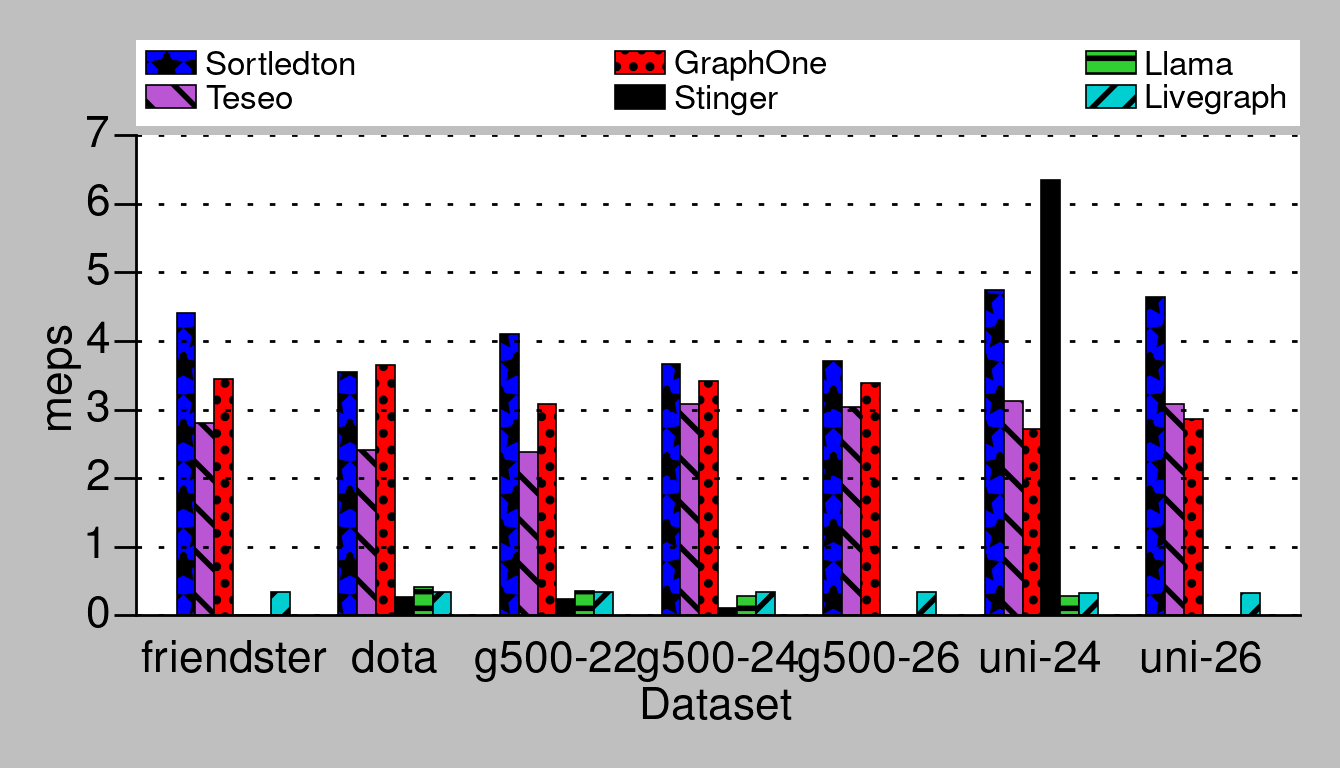

In [5]:
## FIGURE 9

matplotlib.style.use('classic')
colormap=common.set_library_colormap("")

colormap[('graphone', '')] = ('red')

scale_y = 1e6
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))

plotting.latexify(columns=2, fig_height=plotting.cm2inch(5))

p = all_libs.plot.bar(width=0.7, color=colormap, linewidth=0.3)

plt.ylabel("meps")
plt.xlabel("Dataset")

positions = (0, 1, 2, 3, 4, 5, 6)
x_labels = ("friendster", "dota", "g500-22", "g500-24", "g500-26", "uni-24", "uni-26")
plt.xticks(positions, x_labels)
plt.xticks(rotation=0)

#plt.yscale("log")
#plt.ylim(1)
p.yaxis.set_major_formatter(ticks_y)
plt.yticks()

plotting.apply_hatches(['sortledton', 'teseo', 'graphone', 'stinger', 'llama', 'livegraph'], 7, 0, p.patches)

legend_labels = ["Sortledton", "Teseo", "GraphOne", "Stinger", "Llama", "Livegraph"]
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=3, mode="expand", borderaxespad=0., labels=legend_labels).get_frame().set_linewidth(0.0)

#plt.legend(loc='upper center', labels=legend_labels, ncol=6).get_frame().set_linewidth(0.0)

plotting.format_axes(p, categorical_x=True)
p.yaxis.grid(which="minor",b=None)



plt.tight_layout()
plt.savefig(plotting.base_path + "insertions-new.png", dpi=400)